# Electron Density Image Analysis

This notebook is meant to make it easy to select and analyse a series of images for the movement of electron densities when varying current.

In [1]:
%matplotlib widget
import numpy as np
from image_analysis_tools import *
from mapping_tools import *

## Data Selection

In order to follow this notebook you need three images:
1. High extraction voltage (one tight electon spot)
2. Medium extraction voltage (some spread in electrons in the image)
3. Medium with an offset (almost the same spread as the second image, but slightly changed)

Note that it is possible to analyse a series of images if desired.

All non high extraction voltage images should be names as the voltage used for extraction i.e. the difference in potential. E.g. 500.png, 400.png, 489.png.

Input the path of your folders below.

(Main can be either the path to the exact image or the path to the folder of the image (only one image in the folder is allowed).

In [2]:
# Example not functioning with current naming conventions in analysis tools
# high_extraction_directory = "D:\\OneDrive - Danmarks Tekniske Universitet\\OneDrive\\Dokumenter\\DTU\\Terahertz\\PaperExperiments\\AngleAnalysisTestImages\\main\\main.tif"
# other_images = "D:\\OneDrive - Danmarks Tekniske Universitet\\OneDrive\\Dokumenter\\DTU\\Terahertz\\PaperExperiments\\AngleAnalysisTestImages\\others"
# reduced_set = "D:\\OneDrive - Danmarks Tekniske Universitet\\OneDrive\\Dokumenter\\DTU\\Terahertz\\PaperExperiments\\AngleAnalysisTestImages\\reduced_set"

high_extraction_directory = "E:\\EmissionEnergy_Data\\Images\\centers\\08THz_emission_energy_sweep.png"
other_images = "E:\\EmissionEnergy_Data\\Images\\08THz_A_75_to_100_s5_U_1300_to_1700_s20_1\\0.0"
reduced_set = "E:\\EmissionEnergy_Data\\Images\\08THz_A_75_to_100_s5_U_1300_to_1700_s20_1\\reduced_set_angle_0"

## Create Image Series

Using the directories the images are loaded and initial analysis is performed in the form of getting the center spot

In [3]:
images = ImageSeries(high_extraction_directory, other_images, center=[995, 613]) # Center is [995 613] for example images

Main file: 08THz_emission_energy_sweep.png, loaded
Using provided center value:  [995, 613]
Number of settings:  21
Loaded 21 other images


In [4]:
images.subtract_background_all(images.others[f'pos_0_volt{min(images.voltages)}'].data)

In [ ]:
# images.save_reduced_set(path=reduced_set)

## Perform Analysis

The analysis aims to extract three types of information

- $\phi$ angle information (in plane angle of emission)
- $\theta$ angle information (out of plane angle of emission)
- eV (emission energy)



### Binning

For visualization of the distribution of electrons it is possible to bin the intensities. This can be done in both the linear and the logarithmic domain.

In [ ]:
for i,im_name in enumerate(sorted(list(images.others))):
    if i < 8:
        continue
    im = images.others[im_name]
    im.bin_data(bins=25, domain="Linear")
    im.show_binned()

### Slicing

Before performing the analysis pixel devision and slice angle must be selected.

Slice angle is default in degrees, but can be set in radians if unit is set to it. Low angle means many slices.

Pixel devision has to do with asignment of pixels to slice. This is either binary (is in slice or is not) or added to the slice with a weight dependent on the overlapping area.

In [11]:
images.slice_images(center=images.center, angle=5, unit="degrees", assignment="binary")

Visualize the spot with all the slices.

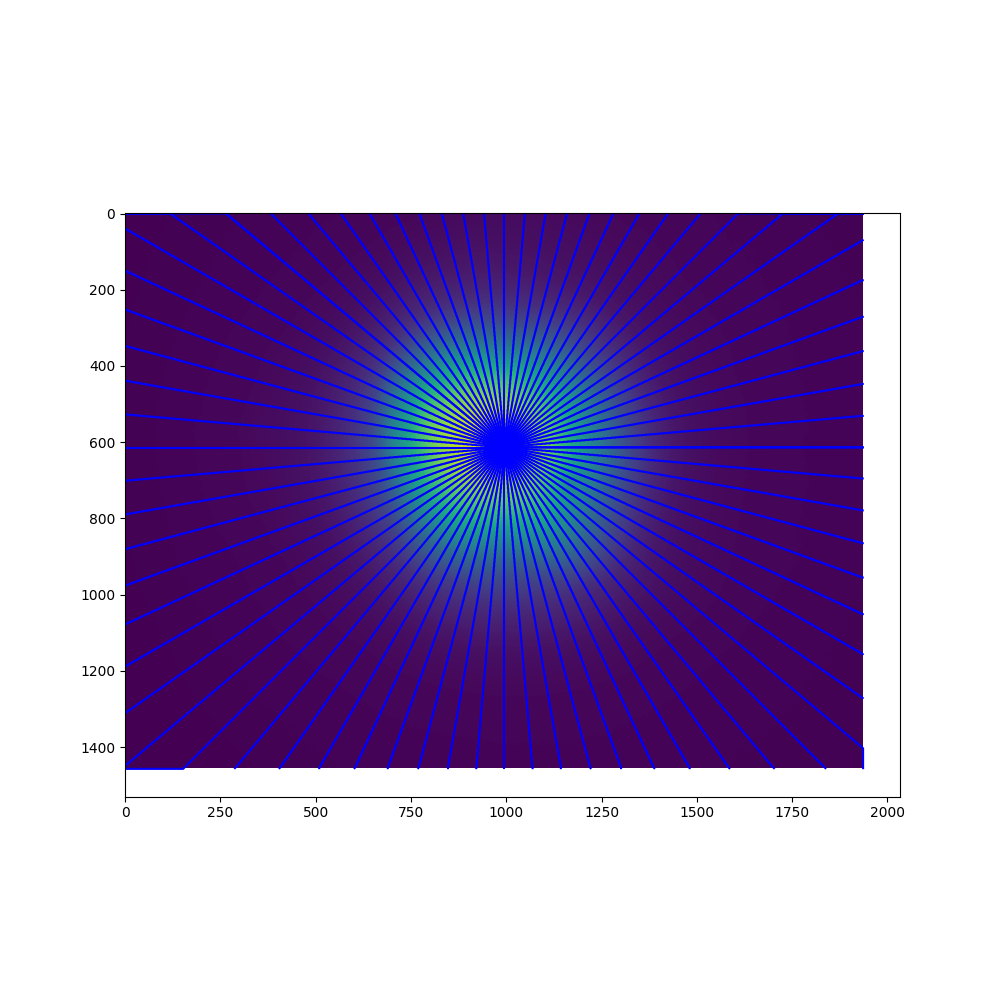

In [26]:
import matplotlib.pyplot as plt
first_image = list(images.others)[-1]
an_image = "pos_0_volt1480"
plt.figure(figsize=(10,10))
plt.imshow(images.others[first_image].data)
plt.plot(images.others[first_image].slices[0].xs + images.center[0], images.others[first_image].slices[0].yls, c='b')
plt.plot(images.others[first_image].slices[140].xs + images.center[0], images.others[first_image].slices[140].yls, c='b')

angle = 5
for i in range(int(360 / angle)):
    v = i * angle
    try:
        plt.plot(images.others[first_image].slices[v].xs + images.center[0], images.others[first_image].slices[v].yus, c='b')
    except:
        plt.plot(images.others[first_image].slices[v].xus, images.others[first_image].slices[v].ys + images.center[1], c='b')
# plt.plot(images.others['100'].slices[95].xus, images.others['100'].slices[95].ys + images.center[1], c='r')

Using the slices a phi plot can be created. This will in general show four peaks. 0 degrees, 90 degrees, 180 degrees, and 270 degrees. The peaks should be approximately the same height. If they are not, the center of the image was probably not hit correctly.

In [ ]:
# for i,im in enumerate(sorted(list(images.others))):
#     if i == 0:
#         continue
#     angles, intensities = images.others[im].get_phi_dependence()
#     print(im)
#     images.others[im].plot_phi_dependence()

### Slice Binning

For each slice we can extract an intensity as a function of distance to the center of the image. In general we neglect the inner most 20 pixels due to defficulty in the slicing algorithm. It is possible to slice them intelligently, so all slices will look nice, but this requires a non binary assignment algorithm.

During the creation of the intensity profile, the intensities are binned. This is done by selecting a number of desired bins which are placed with equal distance along the line. Then the mean of their assigned area is calculated and assigned to the center value of the bin. The bin number is dynamic but must not exceed the number of pixels to the edge. A low number of bins wil reduce resolution but increase the speed of later calculations.

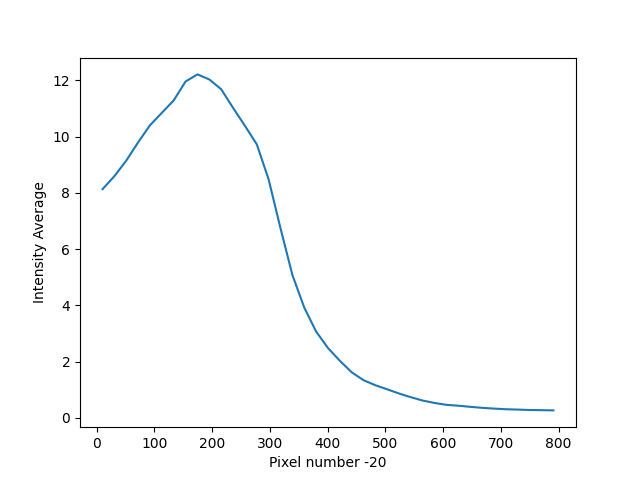

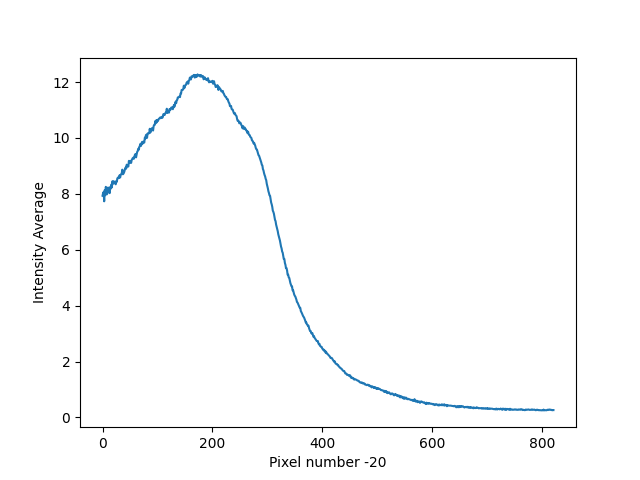

In [28]:
images.others[an_image].slices[235]._generate_binnings(40)
images.others[an_image].slices[235].plot_bins()
images.others[an_image].slices[235].plot()

### Variable Maps

In order to calculate the angles and energies for each position we generate a "map" of the variables and how they relate to the range. This is the (R,$\theta$,E) space.

A map is generated for each applied electric field. For now there is an issue with imposing positive fields...

It takes a short while to generate the maps. In general it is the same set which is usefull. It is saved into a pickle format, so it can be loaded up again easily.

If generating a larger set of maps, just use the outcommented code below with pickle.dump.

In [5]:
# voltages = np.array(images.voltages) - 1500
# maps = MapBook(voltages[voltages < 0])

import pickle
maps = pickle.load(open("E:\\EmissionEnergy_Data\\maps.p","rb"))

In [22]:
maps[-20].get_allowed_angles(0.0005)

0.008916300173092424 1.540490628203014


(0.008916300173092424, 1.2188600193167305)

In [12]:
0.6368617746653602*180/np.pi

36.489491821536795

In [21]:
np.log(maps[-20].intermap(0.0005,0.6))

array([-49.60943492])

In [8]:
# import pickle
# pickle.dump(maps, open("E:\\EmissionEnergy_Data\\maps.p","wb"))

This section resulted in maps for different values of the electric field. These are now accessible in the maps object. It holds a dict with a map connected to the voltage value relative to 1500 V.

Either specific values can be accessed, the maps plotted or interpolated values extracted.

Lets look at a plot and how to get interpolated values.

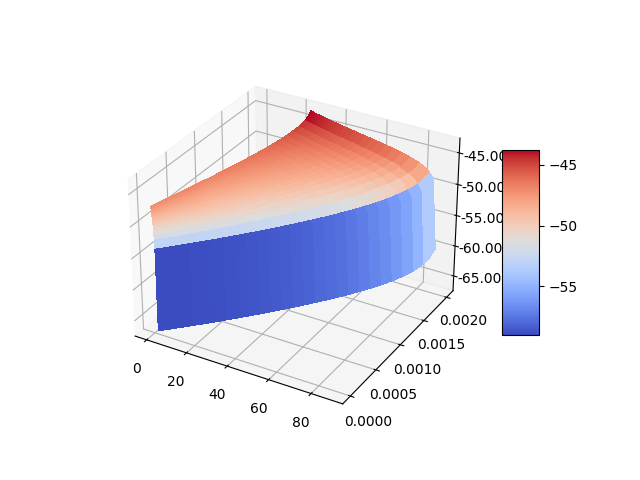

In [8]:
# Shows the mapping of angle and range on screen to the log of the energy in joules
# Angles are from 0 to 90 degrees and range is from close to 0 to around 2 mm
maps[-20].show_3dmap()

Each map holds an interpolated version of the map. This means we do not need to access the specific calculated values, but can extract any value inside the surface.

The interpolation takes a range and an angle or a list of ranges and angles. Note that if both ranges and angles are lists, then an array is outputted with all the combinations of the values.

The interpolation uses cubic interpolation, so the points are not exact to the last decimal. Lets take a look using the 11th range value and the corresponding angle values.

In [10]:
print("Mean values : ", maps[-20].map[10].mean())
print("Mean deviation error : ", (maps[-20].intermap(maps[-20].rs[10], maps[-20].angles[10]) - maps[-20].map[10]).mean())

Mean values :  9.09637336159639e-22
Mean deviation error :  -1.1662071535245355e-25


Due to the very non linear nature of the map, the averages are a bad comparison. However, even with the misrepresentation due to alot of very very small values the deviation is still 1/1000 of the values. So not bad. Lets use it.

### Initial Energy Angle distribution

We now have binned data for slices in images varied over a number of acceleration voltages and maps relating the energy, the angles, and the position on screan. For the slice above, lets then make an initial guess for a set of angles and energies, which result in the correct ranges. This is done by setting the range and selecting the angle values at random. Using the map, we can then interpolate to get the energy. Knowing the energies and the angles can then be used for the next iteration of the problem, which requires an energy, angle to range map instead of an angle, range to energy.

We want to look at the intensity as linearly correlated to a number of electrons. We can scale the intensity up to increase the number of electrons required, increasing the resolution of the final distribution, or we can scale it down to increase computational speed. For now lets just round the bin value numbers to integers.

In [36]:
our_slice = images.others[an_image].slices[235]

scale = 1
pixel_to_meters = 2.2e-6
bin_vals = np.round(our_slice.bin_vals,0).astype(int) * scale
bin_positions = (our_slice.bin_positions + 20) * pixel_to_meters
print("Number of electrons : ", bin_vals)
print("At ranges in mm : ", bin_positions*1000)

Number of electrons :  [ 8  9  9 10 10 11 11 12 12 12 12 11 10 10  8  7  5  4  3  2  2  2  1  1
  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0]
At ranges in mm :  [0.066605 0.111815 0.157025 0.202235 0.247445 0.292655 0.337865 0.383075
 0.428285 0.473495 0.518705 0.563915 0.609125 0.654335 0.699545 0.744755
 0.789965 0.835175 0.880385 0.925595 0.970805 1.016015 1.061225 1.106435
 1.151645 1.196855 1.242065 1.287275 1.332485 1.377695 1.422905 1.468115
 1.513325 1.558535 1.603745 1.648955 1.694165 1.739375 1.784585]


In [21]:
import random

relevant_map = maps[-20]

distribution = {}
for i, r in enumerate(bin_positions):
    lower_angle
    distribution[r] = []
    for el in range(bin_vals[i]):
        distribution[r].append((random.uniform(, 9),))

array([223, 208, 183, 155, 124,  92,  63,  40,  25,  16,  10,   7,   5,
         4,   3,   2,   2,   2,   2])

### Energy-Theta Analysis

A class has been created to analyse the change of the peaks, translating it into energy of emission and angle of emission

In [ ]:
from emission_curves import EmissionCurve

The EmissionCurve class needs three things:
- The distance of first image peak from laser center
- The distance of second image peak from laser center
- The change in extraction voltage

In [ ]:
ptomu = 5e-3 / 723
ECs = [EmissionCurve(r=r, E=E) for r,E in zip([1e-3,0.8e-3, 0.6e-3],[-10,-20,-30])]

import matplotlib.pyplot as plt
import numpy as np

plt.figure()
for ec in ECs:
    plt.plot(ec.angles * 180/np.pi, np.log(ec.curve), label=f"r={ec.r}, E={ec.E}")
plt.xlabel("Angles (deg)")
plt.ylabel("Emission Energy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib

In [ ]:
EC.curve

In [ ]:
np.log(2.04339640e-15)

In [ ]:
emission_angle = EC.angle
emission_energy = EC.E0

In [ ]:
print("Emission Angle in degrees: ", emission_angle * 180 / np.pi)
print("Emission Energy in eV: ", emission_energy)

Generate an angle dependence line for each picture, plot together
Use the lines to find intersections
All lines for the same THz power should intersect at the same spot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
files = ["E:\\EmissionEnergy_Data\\Ampmeter\\08THz_100_40_s1_current_1\\current.csv","E:\\EmissionEnergy_Data\\Ampmeter\\09THz_100_40_s1_current_0\\current.csv"]

In [ ]:
current = [pd.read_csv(file) for file in files]
positions = current[0].position.unique()
currents = [[curr.loc[curr.position == pos, "current"].mean() for pos in positions] for curr in current]
currents = [curr - curr[0] for curr in currents]
e_field = [(np.cos(pos*np.pi/180))**2 for pos in positions]

In [ ]:
import os
os.getcwd()

In [ ]:
plt.figure()
plt.plot(e_field,currents[0], 'bo', label="0.8 THz", markersize=4)
plt.plot(e_field,currents[1], 'ro', label="0.9 THz", markersize=4)
plt.legend()
plt.xlabel("Relative Field Strength")
plt.ylabel("Current [A]")
plt.show()

plt.figure()
plt.plot(e_field[1:],np.log(currents[0][1:]), 'bo', label="0.8 THz", markersize=4)
plt.plot(e_field[1:],np.log(currents[1][1:]), 'ro', label="0.9 THz", markersize=4)
plt.legend()
plt.xlabel("Relative Field Strength")
plt.ylabel("Current [A]")
plt.show()

In [ ]:
files = ["E:\\EmissionEnergy_Data\\PhosCur\\Currents\\08THz_2000V_90_40_100_s1\\voltage_and_currents.csv","E:\\EmissionEnergy_Data\\PhosCur\\Currents\\09THz_2000V_90_40_100_s1\\voltage_and_currents.csv"]

current = [pd.read_csv(file) for file in files]
positions = current[0].position.unique()
currents = [[curr.loc[curr.position == pos, "current3"].mean() for pos in positions] for curr in current]
currents = [curr - curr[0] for curr in currents]
e_field = [(np.cos(pos*np.pi/180))**2 for pos in positions]

In [ ]:
plt.figure()
plt.plot(e_field,currents[0], 'bo', label="0.8 THz", markersize=4)
plt.plot(e_field,currents[1], 'ro', label="0.9 THz", markersize=4)
plt.legend()
plt.xlabel("Relative Field Strength")
plt.ylabel("Current [A]")
plt.show()

plt.figure()
plt.plot(e_field[1:],np.log(currents[0][1:]), 'bo', label="0.8 THz", markersize=4)
plt.plot(e_field[1:],np.log(currents[1][1:]), 'ro', label="0.9 THz", markersize=4)
plt.legend()
plt.xlabel("Relative Field Strength")
plt.ylabel("Current [A]")
plt.show()

In [ ]:
currents[0] == currents[1]

In [ ]:
bins = 10
mi = 0
ma = 11
step = (ma - mi) / bins

t = np.round([mi + step/2] + [mi + i * step + step/2  for i in range(1,bins-2)] + [ma - step/2],2)

In [ ]:
print(t[0])
print(t[1]-t[0])
print(t[2]-t[1])
print(ma - t[-1])

In [ ]:
t

In [ ]:
arr = np.arange(1,10)

In [ ]:
mask1 = arr > 4
mask2 = arr < 9

In [ ]:
mask1 & mask2

In [ ]:
arr[mask2]

In [ ]:
arr

In [ ]:
from emission_curves import EmissionCurve, RangeSurface
ranges = RangeSurface(E=10)
ranges.get_r()